In [1]:
# import libraries
import torch 
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import torchvision 
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision import datasets    
# import image
from PIL import Image
from going_modular import data_setup, engine
import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
IMG_SIZE = 224

manual_transforms = transforms.Compose([
    transforms.Resize([IMG_SIZE, IMG_SIZE]),
    transforms.ToTensor(),
])

(640, 640)


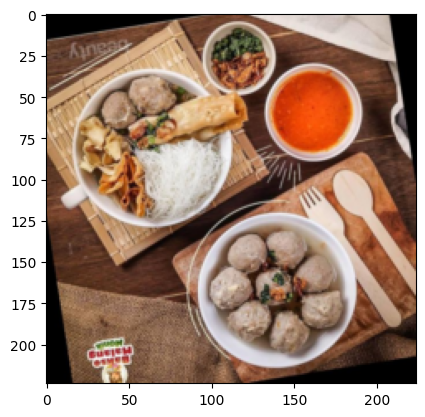

In [4]:
# check resized image
img_path = 'predict_nutrition-1/train/Bakso Malang/6b519be4-5a67-4291-b11d-387ccfee1240_jpeg.rf.7e309457f560479426c3b27666eea0c7.jpg'
img = Image.open(img_path)
print(img.size)
img = manual_transforms(img)
plt.imshow(img.permute(1, 2, 0))

In [6]:
# set batch size
BATCH_SIZE = 32

# create data loaders
train_dataloader, test_dataloader, class_name = data_setup.create_dataloaders(
    train_dir='dataset',
    test_dir='dataset',
    batch_size=BATCH_SIZE,
    transform=manual_transforms
)

train_dataloader, test_dataloader, class_name

NameError: name 'manual_transforms' is not defined

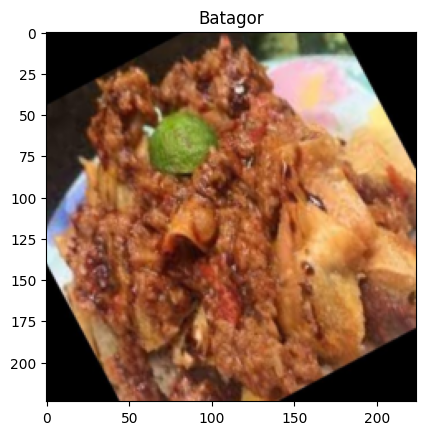

In [6]:
# get batch of image
image_batch, label_batch = next(iter(train_dataloader))

# get single image from batch
image, label = image_batch[0], label_batch[0]

# display image
plt.imshow(image.permute(1, 2, 0))
plt.title(class_name[label.item()])
plt.show()

### Replicate Vision Transformer

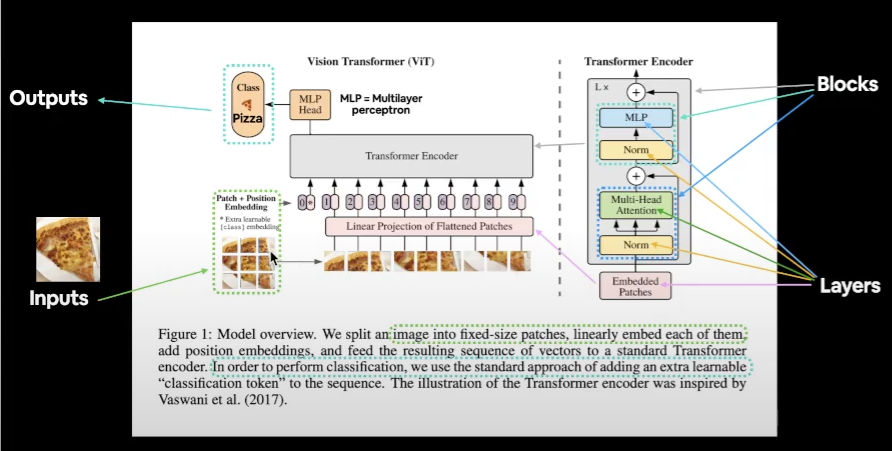

#### 1. Patch Embedding
Turn image into patches

In [7]:
rand_img_tensor = torch.randn(1, 3, 224, 224) # (batch_size, channels, height, width)

In [8]:
class PatchEmbedding(nn.Module):
    def __init__(self, in_channels=3, patch_size=16, embedding_dim=768):
        super().__init__()

        # create a layer to convert image into patches
        self.patcher = nn.Conv2d(
            in_channels=in_channels,
            out_channels=embedding_dim,
            kernel_size=patch_size,
            stride=patch_size,
            padding=0
        )

        self.patch_size = patch_size

        # create a layer to flatten the patch feature maps into single dimension
        self.flatten = nn.Flatten(start_dim=2,
                                  end_dim=3)
        
    def forward(self, x):
        # create assertion to check correct shape
        image_resolution = x.shape[-1]
        assert image_resolution % self.patch_size == 0,  f"Input image size must be divisble by patch size, image shape: {image_resolution}, patch size: {self.patch_size}"

        # perform forward pass
        x_patched = self.patcher(x)
        x_flattened = self.flatten(x_patched).permute(0, 2, 1) # adjust so the embedding is on the final dimension [batch_size, P^2•C, N] -> [batch_size, N, P^2•C]
        return x_flattened

In [9]:
patch_embedding = PatchEmbedding()
patch_embedding_output = patch_embedding(rand_img_tensor)
patch_embedding_output

tensor([[[ 0.3891,  1.3251,  0.4561,  ..., -1.1107, -0.0811,  1.2784],
         [-0.9393, -0.3467,  0.0485,  ...,  0.1098, -0.8158, -0.0360],
         [-0.1476, -0.4051,  0.6295,  ...,  0.3611,  0.1981,  0.3172],
         ...,
         [ 0.5681, -0.3086, -0.0258,  ...,  0.2660,  0.0561, -0.4205],
         [-0.1189, -0.4511, -0.9424,  ...,  1.2763, -0.1393, -0.2081],
         [ 0.3245, -0.3443, -0.0155,  ...,  0.4790, -0.7419,  0.2281]]],
       grad_fn=<PermuteBackward0>)

In [10]:
patch_embedding_output.shape # (batch_size, num_patches, embedding_dim)

torch.Size([1, 196, 768])

#### 2. Transformer Encoder Layer
Alternating Multi Headed Self Attention (MSA) and MLP

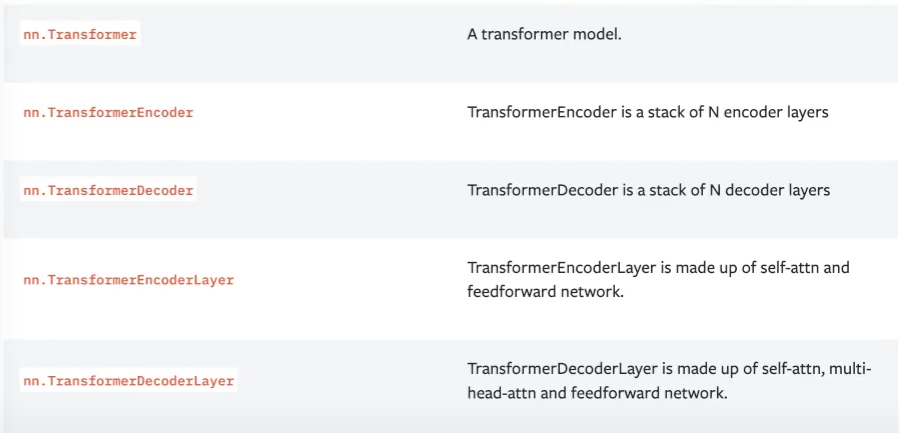

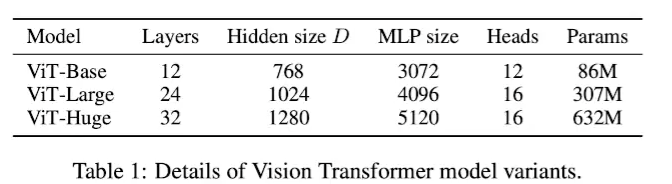

In [11]:
transformer_encoder_layer = nn.TransformerEncoderLayer(d_model=768,
                                                       nhead=12,
                                                       dim_feedforward=3072,
                                                       dropout=0.1,
                                                       activation='gelu',
                                                       batch_first=True)

In [12]:
transformer_encoder_layer_output = transformer_encoder_layer(patch_embedding_output)
transformer_encoder_layer_output

tensor([[[ 1.0448,  1.9730,  0.9120,  ..., -1.9322, -0.3095,  2.0320],
         [-1.5635, -0.5359,  0.2056,  ...,  0.6019, -0.9229,  0.0843],
         [-0.1568, -0.8619,  1.3788,  ...,  1.1743,  0.3817,  0.5071],
         ...,
         [ 1.2689, -0.5060, -0.1768,  ...,  0.2841,  0.0843, -0.6616],
         [-0.6010, -0.5107, -1.5142,  ...,  2.0439, -0.4654, -0.5487],
         [ 0.5595, -0.5358, -0.1645,  ...,  0.4812, -1.2577,  0.5083]]],
       grad_fn=<NativeLayerNormBackward0>)

In [13]:
transformer_encoder_layer_output.shape # (batch_size, num_patches, embedding_dim)

torch.Size([1, 196, 768])

In [14]:
transformer_encoder_layer

TransformerEncoderLayer(
  (self_attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
  )
  (linear1): Linear(in_features=768, out_features=3072, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (linear2): Linear(in_features=3072, out_features=768, bias=True)
  (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (dropout1): Dropout(p=0.1, inplace=False)
  (dropout2): Dropout(p=0.1, inplace=False)
)

In [15]:
from torchinfo import summary

summary(transformer_encoder_layer)

Layer (type:depth-idx)                             Param #
TransformerEncoderLayer                            --
├─MultiheadAttention: 1-1                          1,771,776
│    └─NonDynamicallyQuantizableLinear: 2-1        590,592
├─Linear: 1-2                                      2,362,368
├─Dropout: 1-3                                     --
├─Linear: 1-4                                      2,360,064
├─LayerNorm: 1-5                                   1,536
├─LayerNorm: 1-6                                   1,536
├─Dropout: 1-7                                     --
├─Dropout: 1-8                                     --
Total params: 7,087,872
Trainable params: 7,087,872
Non-trainable params: 0

#### 3. Stack Multiple Transformer Encoder

Stack of 12 of transformer encoder layer

In [16]:
transformer_encoder = nn.TransformerEncoder(encoder_layer=transformer_encoder_layer, 
                                            num_layers = 12)

In [17]:
transformer_encoder(patch_embedding_output)

tensor([[[-3.9894e-01,  1.6393e+00,  4.9583e-01,  ..., -1.8209e-01,
           1.2691e+00,  7.1235e-01],
         [-1.5269e+00,  5.3707e-01,  2.6591e-01,  ...,  4.3447e-01,
           3.4040e-01, -3.7152e-01],
         [-1.6388e+00,  5.5989e-01,  9.8913e-02,  ...,  3.9702e-01,
           1.9979e+00, -2.4621e-01],
         ...,
         [-1.5916e+00,  9.6983e-01,  2.1983e-03,  ...,  5.9956e-01,
           1.8674e+00,  4.2500e-01],
         [-2.1634e+00,  9.5621e-01,  4.1403e-01,  ...,  6.1517e-01,
           9.3736e-01, -8.8585e-02],
         [-2.3434e+00,  7.5739e-01, -6.6568e-01,  ..., -1.5109e-01,
           1.3190e+00,  8.4087e-01]]], grad_fn=<NativeLayerNormBackward0>)

In [18]:
transformer_encoder

TransformerEncoder(
  (layers): ModuleList(
    (0-11): 12 x TransformerEncoderLayer(
      (self_attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
      )
      (linear1): Linear(in_features=768, out_features=3072, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)
      (linear2): Linear(in_features=3072, out_features=768, bias=True)
      (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout1): Dropout(p=0.1, inplace=False)
      (dropout2): Dropout(p=0.1, inplace=False)
    )
  )
)

#### 4. MLP Head

#### 5. Putting All Together (ViT)

In [19]:
class ViT(nn.Module):
    def __init__(self, img_size=224, 
                 patch_size=16,
                 num_channels=3,
                 embedding_dim=768,
                 dropout=0.1,
                 mlp_size=3072,
                 num_transformer_layers=12,
                 num_heads=12,
                 num_classes=1000):
        super().__init__()

        # Assert image size is divisible by patch size
        assert img_size % patch_size == 0, "Image must be divisible by patch size"

    
        # 1. Patch Embedding
        self.patch_embedding = PatchEmbedding(in_channels=num_channels,
                                              patch_size=patch_size,
                                              embedding_dim=embedding_dim)
        
        # 2. Create class token
        self.class_token = nn.Parameter(torch.randn(1, 1, embedding_dim),
                                        requires_grad=True)
        
        # 3. Create positional embedding
        num_patches = (img_size // patch_size) ** 2
        self.positional_embedding = nn.Parameter(torch.randn(1, num_patches + 1, embedding_dim))

        # 4. Create patch + position embedding dropout
        self.embedding_dropout = nn.Dropout(dropout)

        # 5. Create stack of transformer encoder layers
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer=nn.TransformerEncoderLayer(d_model=embedding_dim,
                                                                    nhead=num_heads,
                                                                    dim_feedforward=mlp_size,
                                                                    activation='gelu',
                                                                    norm_first=True,
                                                                    batch_first=True),
                                                         num_layers=num_transformer_layers)

        # 6. Create mlp head
        self.mlp_head = nn.Sequential(
            nn.LayerNorm(embedding_dim),
            nn.Linear(in_features=embedding_dim,
                      out_features=num_classes)
        )

    def forward(self, x):
        # Get some dimension from x
        batch_size = x.shape[0]

        # Create the patch embedding
        x = self.patch_embedding(x)

        # Expand the class token to be the same size as the batch
        class_token = self.class_token.expand(batch_size, -1, -1)

        # Prepend the class token to the patch embedding
        x = torch.cat([class_token, x], dim=1)

        # Add the positional embedding
        x += self.positional_embedding

        # Pass through the embedding dropout
        x = self.embedding_dropout(x)

        # Pass through the transformer encoder
        x = self.transformer_encoder(x)

        # Pass 0th index of x through the mlp head
        x = self.mlp_head(x[:, 0])

        return x




In [20]:
demo_img = torch.randn(1, 3, 224, 224).to(device)
print(demo_img.shape)

vit = ViT(num_classes=len(class_name)).to(device)
vit(demo_img)



torch.Size([1, 3, 224, 224])


/home/irman/anaconda3/envs/zed_sdk/lib/python3.8/site-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


tensor([[-0.3719, -0.4490, -0.0849, -0.9636, -0.3262]], device='cuda:0',
       grad_fn=<AddmmBackward0>)

In [21]:
summary(vit)

Layer (type:depth-idx)                                            Param #
ViT                                                               152,064
├─PatchEmbedding: 1-1                                             --
│    └─Conv2d: 2-1                                                590,592
│    └─Flatten: 2-2                                               --
├─Dropout: 1-2                                                    --
├─TransformerEncoder: 1-3                                         --
│    └─ModuleList: 2-3                                            --
│    │    └─TransformerEncoderLayer: 3-1                          7,087,872
│    │    └─TransformerEncoderLayer: 3-2                          7,087,872
│    │    └─TransformerEncoderLayer: 3-3                          7,087,872
│    │    └─TransformerEncoderLayer: 3-4                          7,087,872
│    │    └─TransformerEncoderLayer: 3-5                          7,087,872
│    │    └─TransformerEncoderLayer: 3-6             

In [22]:
from ViT import ViT

In [23]:
vit2 = ViT(num_classes=len(class_name)).to(device)

vit2(demo_img)

tensor([[-0.0264, -0.2999,  0.8026,  0.1390, -0.5609]], device='cuda:0',
       grad_fn=<AddmmBackward0>)

#### 6. Training

In [3]:
class_name = os.listdir('dataset')
class_name

['soto',
 'bakwan',
 'cireng',
 'tahu_sumedang',
 'rawon',
 'klepon',
 'ketoprak',
 'ayam_geprek',
 'mie_ayam',
 'bakso',
 'bubur_ayam',
 'nasi_kuning']

In [4]:
# 1. First load the pretrained model
vit_weights = torchvision.models.ViT_B_16_Weights.IMAGENET1K_SWAG_E2E_V1
pretrained_vit = torchvision.models.vit_b_16(weights=vit_weights)

# 2. Freeze the base model parameters
for param in pretrained_vit.parameters():
    param.requires_grad = False

# 3. Replace the head
embedding_dim = 768
pretrained_vit.heads = nn.Sequential(
    nn.LayerNorm(embedding_dim),
    nn.Linear(in_features=embedding_dim, out_features=len(class_name))
)

# 4. Unfreeze the head parameters
for param in pretrained_vit.heads.parameters():
    param.requires_grad = True

In [5]:
from torch.utils.data import DataLoader, random_split
from torchvision import datasets
from torch.utils.data import Dataset

# Define the transform for the Vision Transformer
vit_transforms = vit_weights.transforms()

# Set batch size
BATCH_SIZE = 32

# Path to your dataset directory
train_dir = 'dataset'

# Load dataset using ImageFolder
dataset = datasets.ImageFolder(train_dir, transform=vit_transforms)

# Determine the split sizes: 80% for training, 20% for testing
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size

# Split the dataset
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Create DataLoader for train and test datasets
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Class names from the dataset
class_name = dataset.classes

# Return the dataloaders and class names
train_dataloader, test_dataloader, class_name

(<torch.utils.data.dataloader.DataLoader at 0x7c523bceb190>,
 ['ayam_geprek',
  'bakso',
  'bakwan',
  'bubur_ayam',
  'cireng',
  'ketoprak',
  'klepon',
  'mie_ayam',
  'nasi_kuning',
  'rawon',
  'soto',
  'tahu_sumedang'])

In [6]:
len(train_dataloader), len(test_dataloader)

(39, 10)

In [7]:
# set seeds
def set_seeds(seed=42):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

set_seeds(42)

# train
optimizer = optim.AdamW(params=pretrained_vit.parameters(), lr=1e-3)
loss = nn.CrossEntropyLoss()

pretrained_vit_results = engine.train(model=pretrained_vit,
                                      train_dataloader=train_dataloader,
                                      test_dataloader=test_dataloader,
                                      optimizer=optimizer,
                                      loss_fn=loss,
                                      device=device,
                                      epochs=10)


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1728 | train_acc: 0.6803 | test_loss: 0.4869 | test_acc: 0.8958
Epoch: 2 | train_loss: 0.3180 | train_acc: 0.9399 | test_loss: 0.3157 | test_acc: 0.9420
Epoch: 3 | train_loss: 0.2113 | train_acc: 0.9615 | test_loss: 0.2552 | test_acc: 0.9483
Epoch: 4 | train_loss: 0.1489 | train_acc: 0.9784 | test_loss: 0.2122 | test_acc: 0.9451
Epoch: 5 | train_loss: 0.1039 | train_acc: 0.9904 | test_loss: 0.1932 | test_acc: 0.9514
Epoch: 6 | train_loss: 0.0876 | train_acc: 0.9944 | test_loss: 0.1818 | test_acc: 0.9451
Epoch: 7 | train_loss: 0.0718 | train_acc: 0.9944 | test_loss: 0.1678 | test_acc: 0.9458
Epoch: 8 | train_loss: 0.0576 | train_acc: 0.9984 | test_loss: 0.1583 | test_acc: 0.9545
Epoch: 9 | train_loss: 0.0482 | train_acc: 0.9984 | test_loss: 0.1562 | test_acc: 0.9576
Epoch: 10 | train_loss: 0.0429 | train_acc: 0.9984 | test_loss: 0.1509 | test_acc: 0.9490


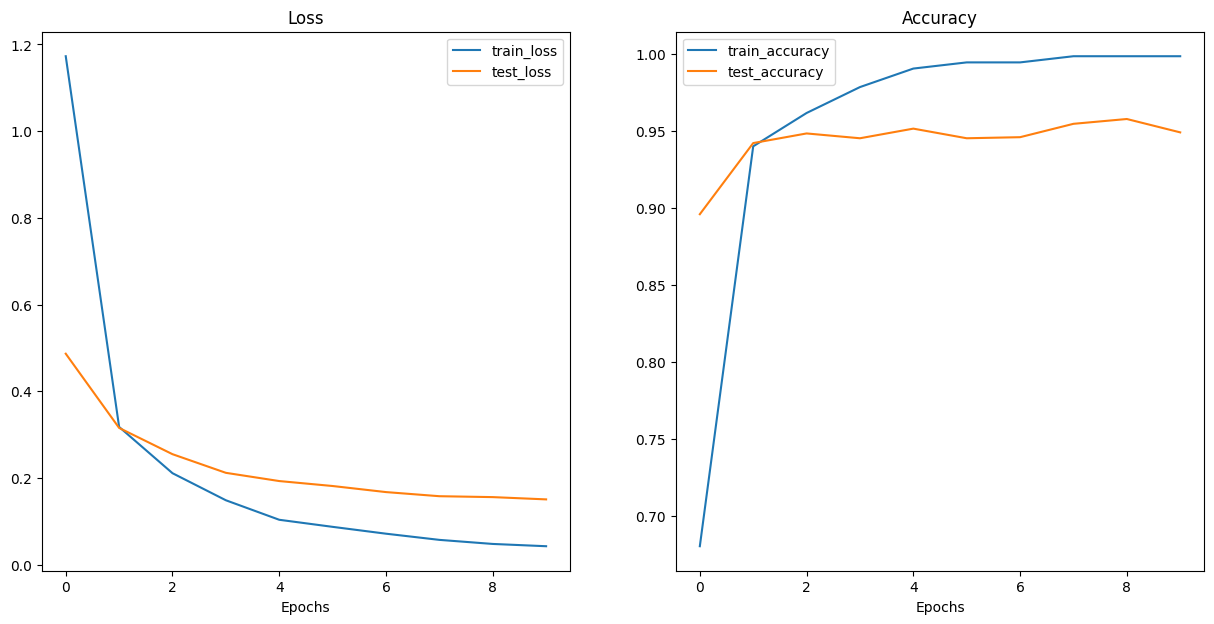

In [8]:
from helper_functions import plot_loss_curves
plot_loss_curves(pretrained_vit_results)

In [9]:
# save model
torch.save(pretrained_vit.state_dict(), 'pretrained_vit_v4.pth')

#### Load Trained Model

In [10]:
# Define the embedding dimension and number of classes
embedding_dim = 768
num_classes = len(class_name)  # Set based on your class names

# Load the model with predefined weights for initialization
vit_weights = torch.load('pretrained_vit_v4.pth')
vit_v1 = torchvision.models.vit_b_16(weights=vit_weights)

# Replace the head with nn.Sequential to chain layers
vit_v1.heads = nn.Sequential(
    nn.LayerNorm(embedding_dim),
    nn.Linear(in_features=embedding_dim, out_features=num_classes)
)

# Define transforms that maintain color accuracy
vit_transforms = transforms.Compose([
    transforms.Resize((384, 384)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Denormalize function
def denormalize(tensor):
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1).to(tensor.device)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1).to(tensor.device)
    return tensor * std + mean

/home/irman/anaconda3/envs/zed_sdk/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ViT_B_16_Weights.IMAGENET1K_V1`. You can also use `weights=ViT_B_16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


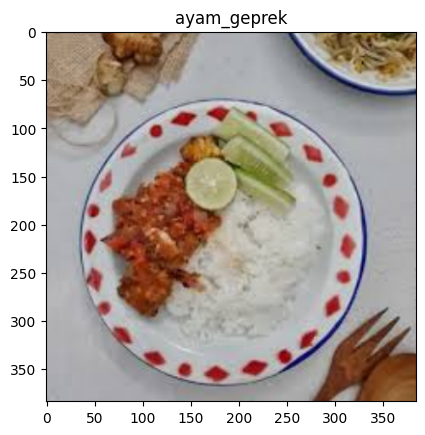

In [16]:
# Load and transform the image
img_test = Image.open('/home/irman/Documents/Vision-Transformer-Intelligence-System-Project/dataset/ayam_geprek/image_482.jpg')
img_test = vit_transforms(img_test).unsqueeze(0).to(device)

# Move the model to the same device as the input tensor
pretrained_vit.to(device)
pretrained_vit.eval()

# Make prediction
with torch.no_grad():
    preds = pretrained_vit(img_test)
    predicted_class = class_name[torch.argmax(preds).item()]

# Display the image with predicted class
img_display = denormalize(img_test.squeeze(0)).permute(1, 2, 0).cpu().clamp(0, 1)
plt.imshow(img_display)
plt.title(predicted_class)
plt.show()

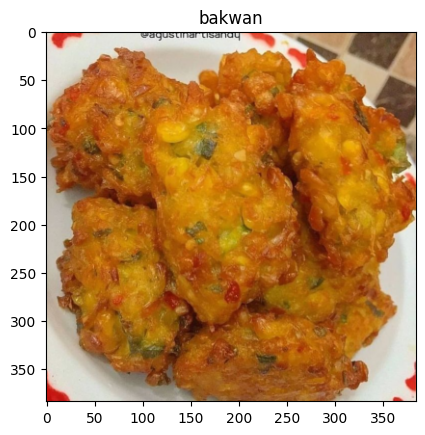

In [17]:
# predict
img_test = Image.open('/home/irman/Documents/Vision-Transformer-Intelligence-System-Project/dataset/bakwan/bakwan (2).jpg')
img_test = vit_transforms(img_test).unsqueeze(0).to(device)

# Move the model to the same device as the input tensor
pretrained_vit.to(device)
pretrained_vit.eval()

# Make prediction
with torch.no_grad():
    preds = pretrained_vit(img_test)
    predicted_class = class_name[torch.argmax(preds).item()]

# Display the image with predicted class
img_display = denormalize(img_test.squeeze(0)).permute(1, 2, 0).cpu().clamp(0, 1)
plt.imshow(img_display)
plt.title(predicted_class)
plt.show()

In [31]:
from collections import defaultdict

def predict_image_grid(model, dataset_path, class_names, vit_transforms, denormalize, device, grid_size=(3,3), seed=42):
    """
    Display a grid of random images with their predictions.
    Ensures better class diversity in the selection process.
    """
    # Set random seed
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
    
    # Initialize statistics
    stats = {
        'total_images': 0,
        'images_processed': 0,
        'selected_classes': [],
        'correct_predictions': 0
    }
    
    # Collect all valid image paths grouped by class
    dataset_path = Path(dataset_path)
    class_dirs = sorted([d for d in os.listdir(dataset_path) if (dataset_path / d).is_dir()])
    class_image_dict = defaultdict(list)
    
    for class_dir in class_dirs:
        class_path = dataset_path / class_dir
        for ext in ['*.jpg', '*.jpeg', '*.png', '*.JPG', '*.JPEG', '*.PNG']:
            class_image_dict[class_dir].extend(list(class_path.glob(ext)))
    
    # Randomly select images with class diversity
    total_images = grid_size[0] * grid_size[1]
    selected_images = []
    class_names_list = list(class_image_dict.keys())
    while len(selected_images) < total_images:
        random.shuffle(class_names_list)  # Shuffle class order for more randomness
        for class_name in class_names_list:
            if class_image_dict[class_name]:  # Ensure the class has remaining images
                img_path = random.choice(class_image_dict[class_name])
                class_image_dict[class_name].remove(img_path)
                selected_images.append((str(img_path), class_name))
            if len(selected_images) == total_images:
                break
    
    stats['total_images'] = len(selected_images)
    
    # Display images in a grid
    fig, axes = plt.subplots(grid_size[0], grid_size[1], figsize=(15, 15))
    axes = np.array(axes).reshape(-1)  # Flatten axes for convenience

    for ax, (image_path, true_class) in zip(axes, selected_images):
        try:
            img = Image.open(image_path).convert('RGB')
            img_tensor = vit_transforms(img).unsqueeze(0).to(device)
            
            # Make prediction
            model.eval()
            with torch.no_grad():
                preds = model(img_tensor)
                probs = torch.softmax(preds, dim=1)[0]
                predicted_idx = torch.argmax(probs).item()
                predicted_class = class_names[predicted_idx]
                confidence = probs[predicted_idx].item()
            
            # Update statistics
            stats['images_processed'] += 1
            stats['selected_classes'].append(true_class)
            if predicted_class == true_class:
                stats['correct_predictions'] += 1
            
            # Display image
            img_display = denormalize(img_tensor.squeeze(0)).permute(1, 2, 0).cpu().numpy()
            img_display = np.clip(img_display, 0, 1)
            
            ax.imshow(img_display)
            
            title_color = 'green' if predicted_class == true_class else 'red'
            title = f'True: {true_class}\nPred: {predicted_class}\nConf: {confidence:.2f}'
            ax.set_title(title, fontsize=10, color=title_color)
            ax.axis('off')
            
        except Exception as e:
            print(f"Error processing {image_path}: {e}")
            ax.text(0.5, 0.5, 'Error loading image', 
                          horizontalalignment='center',
                          verticalalignment='center')
            ax.axis('off')
    
    # Add accuracy as a subtitle
    accuracy = (stats['correct_predictions'] / stats['images_processed'] * 100) if stats['images_processed'] > 0 else 0
    plt.suptitle(f'Accuracy: {accuracy:.1f}%', y=0.95)
    
    plt.tight_layout()
    plt.show()
    
    return stats


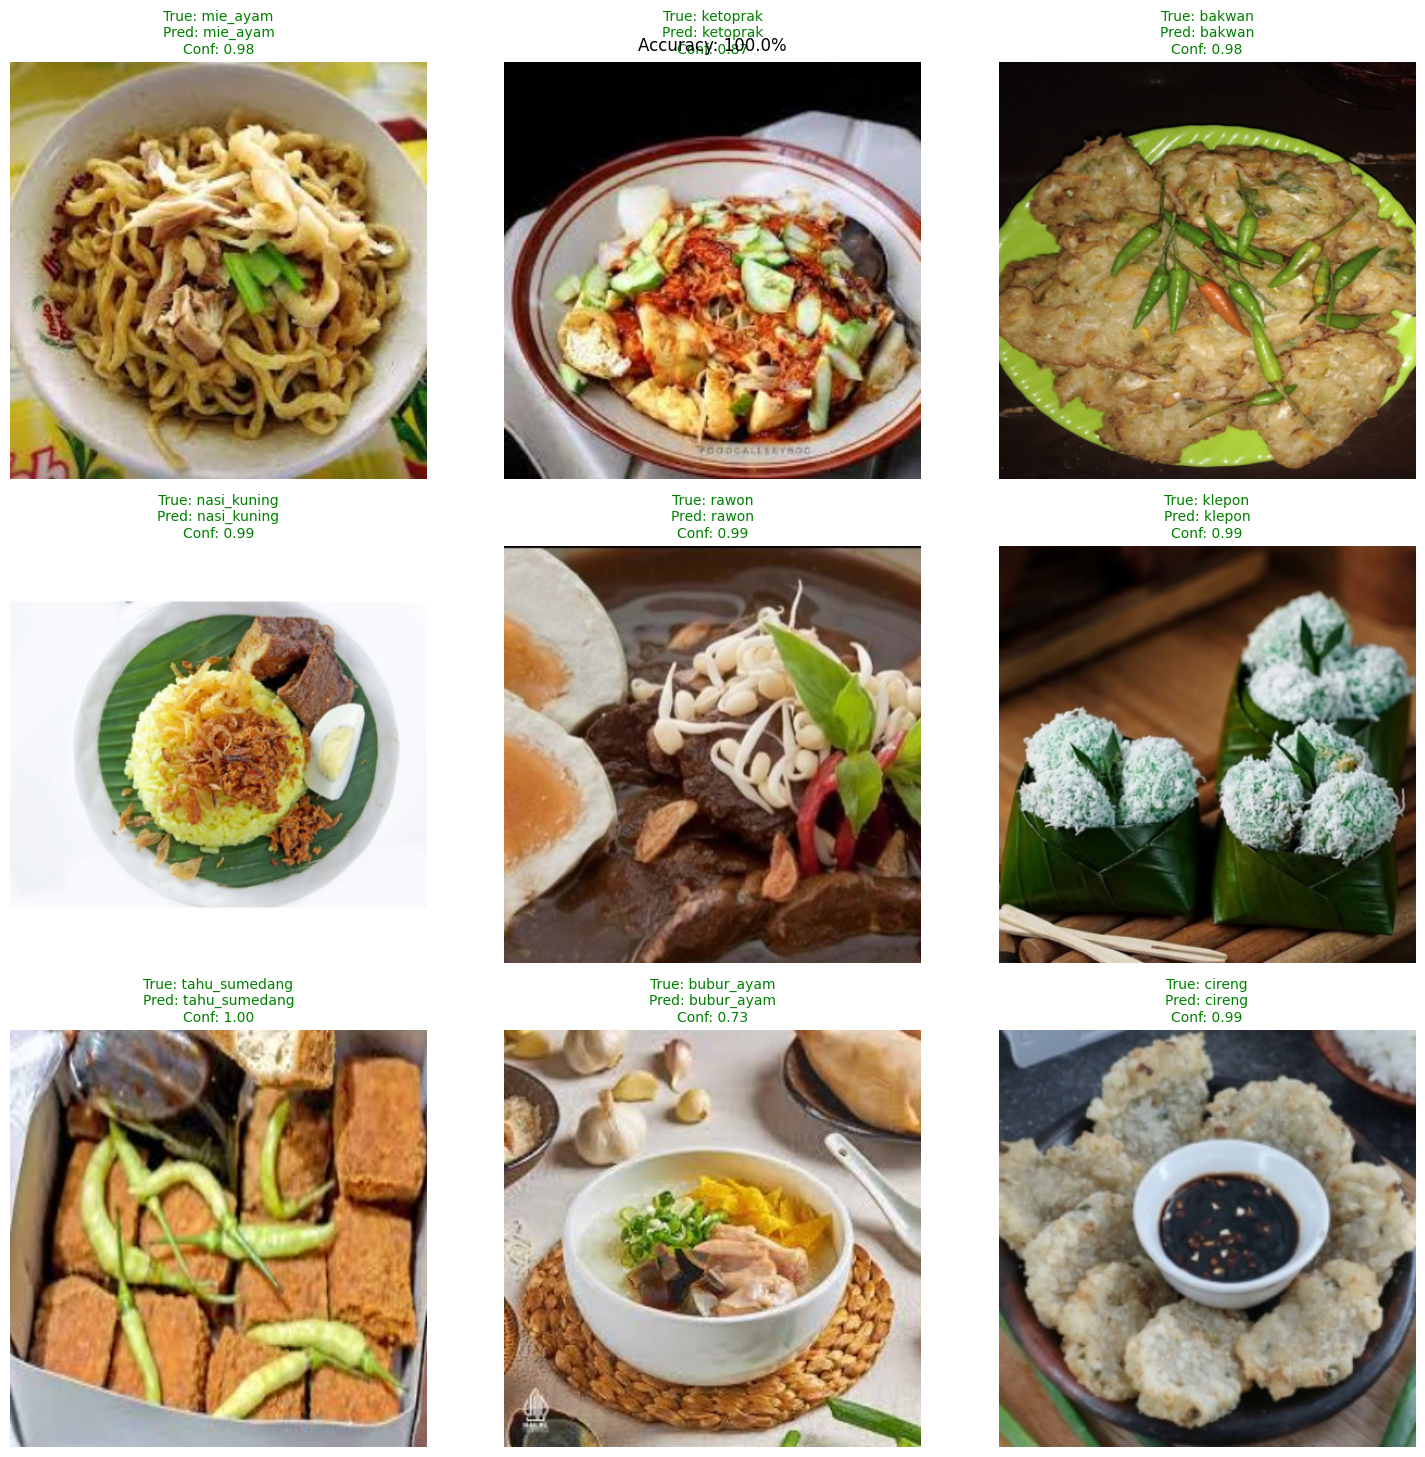


Prediction Statistics:
Total images selected: 9
Images successfully processed: 9
Number of classes represented: 9
Correct predictions: 9
Accuracy: 100.0%


In [32]:
dataset_path = '/home/irman/Documents/Vision-Transformer-Intelligence-System-Project/dataset'

try:
    stats = predict_image_grid(
        model=pretrained_vit,
        dataset_path=dataset_path,
        class_names=class_name,
        vit_transforms=vit_transforms,
        denormalize=denormalize,
        device=device
    )
    
    # Print statistics
    print("\nPrediction Statistics:")
    print(f"Total images selected: {stats['total_images']}")
    print(f"Images successfully processed: {stats['images_processed']}")
    print(f"Number of classes represented: {len(set(stats['selected_classes']))}")
    print(f"Correct predictions: {stats['correct_predictions']}")
    print(f"Accuracy: {(stats['correct_predictions'] / stats['images_processed'] * 100):.1f}%")
    
except Exception as e:
    print(f"An error occurred: {e}")

#### Loaded Model

In [27]:
import torch
import torchvision
import torch.nn as nn

def load_vit_model(weights_path, num_classes, device='cuda'):
    """
    Load a Vision Transformer model with saved weights
    
    Args:
        weights_path: Path to the saved model weights
        num_classes: Number of output classes
        device: Device to load the model on
    
    Returns:
        loaded_model: The loaded model with correct weights
    """
    # Define the embedding dimension
    embedding_dim = 768
    
    # First create the base model with pretrained weights
    model = torchvision.models.vit_b_16(weights='IMAGENET1K_SWAG_E2E_V1')
    
    # Replace the head
    model.heads = nn.Sequential(
        nn.LayerNorm(embedding_dim),
        nn.Linear(in_features=embedding_dim, out_features=num_classes)
    )
    
    # Load the saved state dict
    state_dict = torch.load(weights_path, map_location=device)
    
    # Load the weights into the model
    model.load_state_dict(state_dict)
    
    # Move model to device
    model = model.to(device)
    
    # Set to evaluation mode
    model.eval()
    
    return model


# Parameters
weights_path = 'pretrained_vit_v4.pth'
num_classes = len(class_name)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load the model
loaded_vit = load_vit_model(
    weights_path=weights_path,
    num_classes=num_classes,
    device=device
)

# Test the model is loaded correctly
print("Model loaded successfully.")
print(f"Number of classes: {num_classes}")
print(f"Device: {device}")

Model loaded successfully.
Number of classes: 12
Device: cuda


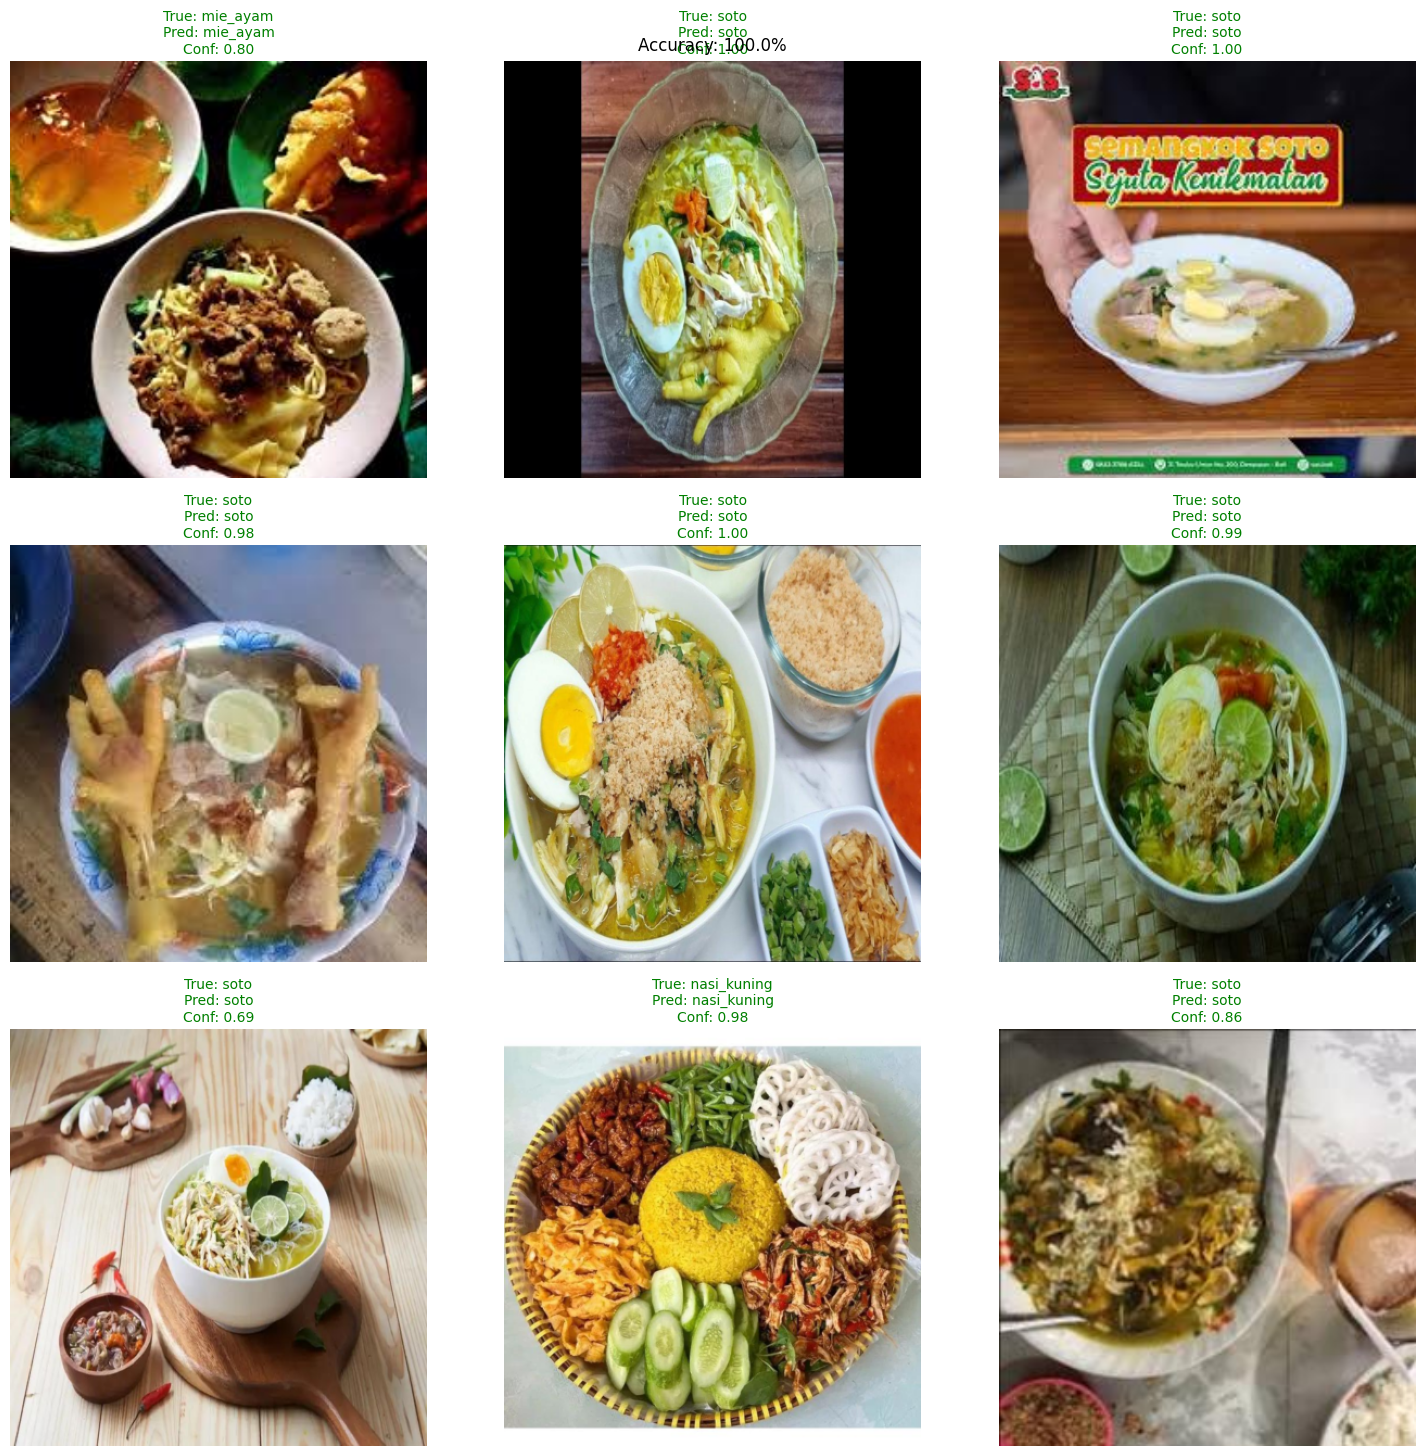


Prediction Statistics:
Total images selected: 9
Images successfully processed: 9
Number of classes represented: 3
Correct predictions: 9
Accuracy: 100.0%


In [28]:
dataset_path = '/home/irman/Documents/Vision-Transformer-Intelligence-System-Project/dataset'

try:
    stats = predict_image_grid(
        model=loaded_vit,
        dataset_path=dataset_path,
        class_names=class_name,
        vit_transforms=vit_transforms,
        denormalize=denormalize,
        device=device
    )
    
    # Print statistics
    print("\nPrediction Statistics:")
    print(f"Total images selected: {stats['total_images']}")
    print(f"Images successfully processed: {stats['images_processed']}")
    print(f"Number of classes represented: {len(set(stats['selected_classes']))}")
    print(f"Correct predictions: {stats['correct_predictions']}")
    print(f"Accuracy: {(stats['correct_predictions'] / stats['images_processed'] * 100):.1f}%")
    
except Exception as e:
    print(f"An error occurred: {e}")